In [332]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


In [333]:
co2.frame.describe(include='all')

,year,month,day,weight,flag,station,co2
count,2225.000000,2225.000000,2225.000000,2225.000000,2225.0,2225,2225.000000
unique,NaN,NaN,NaN,NaN,NaN,1,NaN
top,NaN,NaN,NaN,NaN,NaN,MLO,NaN
freq,NaN,NaN,NaN,NaN,NaN,2225,NaN
mean,1980.026067,6.568989,15.725393,5.816180,0.0,NaN,340.142247
std,12.495512,3.451596,8.796644,1.381698,0.0,NaN,17.003885
min,1958.000000,1.000000,1.000000,1.000000,0.0,NaN,313.000000
25%,1969.000000,4.000000,8.000000,5.000000,0.0,NaN,324.800000
50%,1980.000000,7.000000,16.000000,6.000000,0.0,NaN,338.300000
75%,1991.000000,10.000000,23.000000,7.000000,0.0,NaN,354.800000


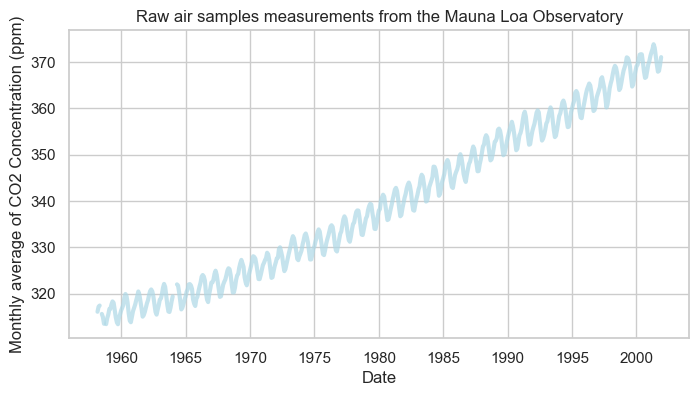

In [334]:
import polars as pl
import pandas as pd

# co2_df = pl.DataFrame(co2.frame[['year', 'month', 'day', 'co2']]).select(
#     pl.date('year', 'month', 'day'), 'co2'
# )

df = co2.frame[['year', 'month', 'day', 'co2']].copy()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df = df[['date', 'co2']]

co2_df_na = df.sort_values('date').resample('MS', on='date')['co2'].mean().reset_index() # .dropna().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
missing_mask = co2_df_na['co2'].isna()
sns.lineplot(data=co2_df_na, x='date', y='co2', hue=missing_mask.cumsum(), palette=['lightblue']*(1+sum(missing_mask)), legend=False, linewidth=3, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Monthly average of CO2 Concentration (ppm)')
plt.title('Raw air samples measurements from the Mauna Loa Observatory')
plt.show()

co2_df = co2_df_na.dropna().reset_index()

In [335]:
import numpy as np

X = np.asarray((co2_df['date'].dt.year + co2_df['date'].dt.month/12)).reshape(-1, 1)
y = np.asarray(co2_df['co2']).reshape(-1, 1)

# Kernel Design

In [336]:
from sklearn.gaussian_process.kernels import Kernel, RBF, ExpSineSquared, RationalQuadratic, WhiteKernel

# Long term rising trend -> Radial Basis Function (RBF) kernel with a large length-scale parameter
long_term_trend_kernel = 50**2 * RBF(length_scale=50)

# Seasonal vairation -> Periodic exponential sine squared kernel with fixed periodicity (1 year)
seasonal_kernel = (
    2**2
    * RBF(length_scale=100) # Allow decaying away from exact periodicity
    * ExpSineSquared(length_scale=1, periodicity=1, periodicity_bounds='fixed')
)

# Small irregularities
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1, alpha=1)

# Noise
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel( # RBF explains the correlated noise component (local weather phenomena) ; WhiteKernel explains the white noise
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

# Final Kernel
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

# Gaussian Process

In [337]:
from sklearn.gaussian_process import GaussianProcessRegressor

gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False) # Do not normalise (dividing y by its std) to keep the hyperparameters expressed in ppm
gaussian_process.fit(X, y - y.mean()) # Substract the mean from the target (literature)
# -> Hyperparameters of the kernel have been optimised

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

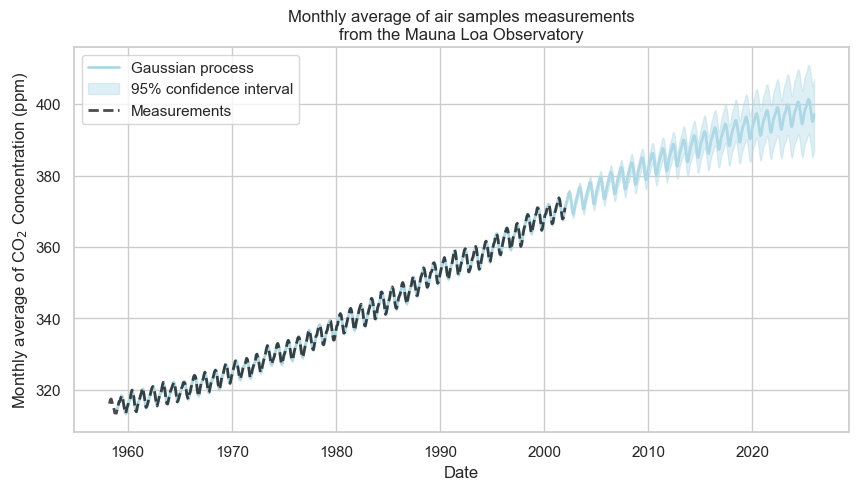

In [338]:
import datetime

today = datetime.datetime.now()
current_month = today.year + today.month/12

X_test = np.linspace(start=1959, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y.mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=X_test.ravel(), y=mean_y_pred, color='lightblue', linewidth=2, label='Gaussian process')
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - 1.96 * std_y_pred,
    mean_y_pred + 1.96 * std_y_pred,
    color='lightblue',
    alpha=0.4,
    label=f'95% confidence interval'
)
sns.lineplot(x=X.ravel(), y=y.ravel(), color='black', linestyle='dashed', linewidth=2, alpha=0.7, label='Measurements')
plt.xlabel('Date')
plt.ylabel('Monthly average of CO$_2$ Concentration (ppm)')
plt.title('Monthly average of air samples measurements\nfrom the Mauna Loa Observatory')
plt.show()

# Kernel visualisation

&rarr; Kernels = Covariance functions &rarr; Determine the shape of prior and posterior and the similarity of two datapoints &rarr; Similar datapoints should have similar target values

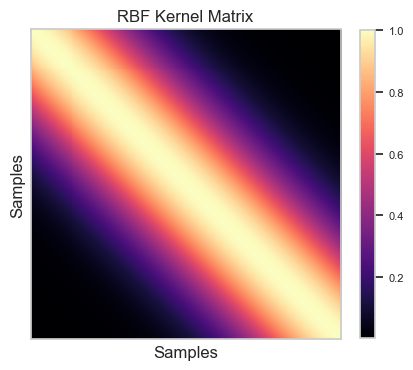

In [339]:
# Visualise the kernel matrix of RBF kernel
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels


# Instantiate RBF kernel with a chosen length_scale (matches how RBF is parameterised)
rbf_kernel = RBF(length_scale=10)
white_kernel = WhiteKernel(noise_level=1)

cov = np.dot(X.T, X) # covariance matrix
d = np.abs(X - X.T) # distance matrix based on Euclidean distance
l = 10 # length-scale parameter
K = np.exp(-d**2/(2*l**2)) # RBF

# Evaluate kernel to obtain covariance / Gram matrix: k(X_sample, X_sample)
K_rbf = rbf_kernel(X)
K_white = white_kernel(X)

fig, ax = plt.subplots(figsize=(5,5))
cax = ax.imshow(K_rbf, cmap='magma', aspect='equal')
# sns.heatmap(K, cmap='magma', square=True, cbar=True, cbar_kws={'shrink' : 0.8}, xticklabels=False, yticklabels=False)
ax. set_title('RBF Kernel Matrix')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

cbar = fig.colorbar(cax, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=8)

plt.xlabel('Samples')
plt.ylabel('Samples')
plt.show()

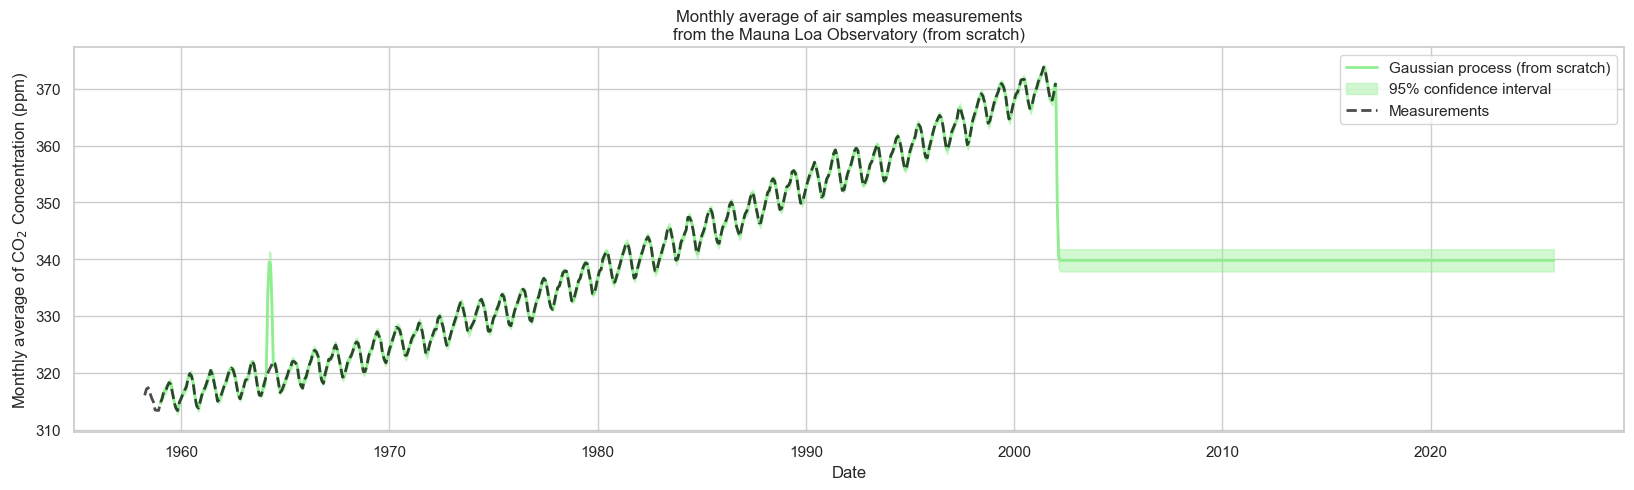

In [341]:
# def RBF_kernel(X, l=1):
#     K = np.exp(np.abs(X - X.T)**2 / (2*l**2))
#     return K

def gaussian_process_regressor(X_train, y_train, X_test, kernel, noise=1e-8):

    # Compute the covariance matrices
    K = pairwise_kernels(X_train, X_train, metric=kernel) + noise * np.eye(len(X_train))
    K_s = pairwise_kernels(X_train, X_test, metric=kernel)
    K_ss = pairwise_kernels(X_test, X_test, metric=kernel)

    # Inverse of K
    K_inv = np.linalg.inv(K)

    # Predictive mean
    mu_s = K_s.T @ K_inv @ y_train

    # Predictive variance
    cov_s = K_ss - K_s.T @ K_inv @ K_s
    std_s = np.sqrt(np.maximum(np.diag(cov_s), 0)) # Ensure positive value

    return mu_s, std_s

# Example usage with RBF kernel but from sklearn
mu_s, std_s = gaussian_process_regressor(X, y - y.mean(), X_test, RBF(length_scale=0.05)) # gaussian_process.kernel_
mu_s += y.mean()

# Plot the results
plt.figure(figsize=(20, 5))
sns.lineplot(x=X_test.ravel(), y=mu_s.ravel(), color='lightgreen', linewidth=2, label='Gaussian process (from scratch)')
plt.fill_between(
    X_test.ravel(),
    mu_s.ravel() - 1.96 * std_s,
    mu_s.ravel() + 1.96 * std_s,
    color='lightgreen',
    alpha=0.4,
    label=f'95% confidence interval'
)
sns.lineplot(x=X.ravel(), y=y.ravel(), color='black', linestyle='dashed', linewidth=2, alpha=0.7, label='Measurements')
plt.xlabel('Date')
plt.ylabel('Monthly average of CO$_2$ Concentration (ppm)')
plt.title('Monthly average of air samples measurements\nfrom the Mauna Loa Observatory (from scratch)')
plt.show()

433.33333333333326